# __Traffic Volume Prediction__
<h2 align="center"><b>Advanced Data Science Capstone Poject by</b></h2>
<h2 align="center"><b>IBM / Coursera</b></h1>
<h2 align=center>Vasilis Kokkinos (September 2019)</h2>

 ## Introduction / Business Problem

USE CASE: Predictive model of traffic volume. It can be used as template for similar situations.

DATA SET: Metro Interstate Traffic Volume Data Set
Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.

Source: https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume



### __Attribute Information:__

__holiday:__ Categorical US National holidays plus regional holiday, Minnesota State Fair

__temp:__ Numeric Average temp in kelvin

__rain_1h:__ Numeric Amount in mm of rain that occurred in the hour

__snow_1h:__ Numeric Amount in mm of snow that occurred in the hour

__clouds_all:__ Numeric Percentage of cloud cover

__weather_main:__ Categorical Short textual description of the current weather

__weather_description:__ Categorical Longer textual description of the current weather

__date_time:__ DateTime Hour of the data collected in local CST time

__traffic_volume:__ Numeric Hourly I-94 ATR 301 reported westbound traffic volume

# __Initial Data Exploration__

Import necessary packages, initialize Apache Spark session, and add supporting functions

In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
%matplotlib inline

import numpy as np

In [2]:
spark = SparkSession.builder.appName('Traffic Volume Prediction').getOrCreate()
spark

Create an sql context so that we can query data files in sql like syntax

In [3]:
sqlContext = SQLContext(spark)

#### __Function to create visually appealing boxplots__

In [4]:
def create_boxplot(df, columns, size=(5, 3), title=''):
    df.createOrReplaceTempView('dataframe')
    cols = 0
    # Since the number of rows in the dataframe is not too high, we can afford to use ALL the data points
    for column in columns:
        result = spark.sql('select ' + column + ' from dataframe order').rdd.sample(False, 0.99).map(lambda row: row[column]).collect()
        if cols == 0:
            data = result
            cols = 1
        else:
            data = [data, result]

    data = np.array(data)
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111)

    bp = ax.boxplot(data)
    bp = ax.boxplot(data, patch_artist=True)

    for box in bp['boxes']:
        # change outline color
        box.set(color='#7570b3', linewidth=2)
        # change fill color
        box.set(facecolor = '#1e3aab')

    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)

    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='#b2df8a', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)

    # Change x-axis labels and remove tick marks from the top and right axes.
    ## Custom x-axis labels
    ax.set_xticklabels(columns)

    ## Remove top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    ax.set_title(title)

    plt.show()

#### __Define the data set schema__

In [5]:
from pyspark.sql.types import (StructType, StructField, DoubleType,
                               IntegerType, StringType, TimestampType)

traffic_schema = StructType([StructField('holiday', StringType(), True),
                            StructField('temp', DoubleType(), True),
                            StructField('rain_1h', DoubleType(), True ),
                            StructField('snow_1h', DoubleType(), True),
                            StructField('clouds_all', IntegerType(), True),
                            StructField('weather_main', StringType(), True  ),
                            StructField('weather_description', StringType(), True ),
                            StructField('date_time', TimestampType(), True ),
                            StructField('traffic_volume', IntegerType(), True)
                            ])

#### __Read in the data set__

In [6]:
df = spark.read.csv('Metro_Interstate_Traffic_Volume.csv',
                     header = True, 
                     schema = traffic_schema)
df.createOrReplaceTempView('df')
df.printSchema()

root
 |-- holiday: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- rain_1h: double (nullable = true)
 |-- snow_1h: double (nullable = true)
 |-- clouds_all: integer (nullable = true)
 |-- weather_main: string (nullable = true)
 |-- weather_description: string (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- traffic_volume: integer (nullable = true)



### Basic data set checks

In [7]:
df.show(20, truncate=False)

+-------+------+-------+-------+----------+------------+-------------------+-------------------+--------------+
|holiday|temp  |rain_1h|snow_1h|clouds_all|weather_main|weather_description|date_time          |traffic_volume|
+-------+------+-------+-------+----------+------------+-------------------+-------------------+--------------+
|None   |288.28|0.0    |0.0    |40        |Clouds      |scattered clouds   |2012-10-02 09:00:00|5545          |
|None   |289.36|0.0    |0.0    |75        |Clouds      |broken clouds      |2012-10-02 10:00:00|4516          |
|None   |289.58|0.0    |0.0    |90        |Clouds      |overcast clouds    |2012-10-02 11:00:00|4767          |
|None   |290.13|0.0    |0.0    |90        |Clouds      |overcast clouds    |2012-10-02 12:00:00|5026          |
|None   |291.14|0.0    |0.0    |75        |Clouds      |broken clouds      |2012-10-02 13:00:00|4918          |
|None   |291.72|0.0    |0.0    |1         |Clear       |sky is clear       |2012-10-02 14:00:00|5181    

In [8]:
print('Number of entries in the dataframe: {}'.format(df.count()))

Number of entries in the dataframe: 48204


#### Check the values for 'holiday' column

In [9]:
spark.sql('select holiday, count(*) from df group by holiday').show(50, truncate=False)

+-------------------------+--------+
|holiday                  |count(1)|
+-------------------------+--------+
|None                     |48143   |
|Thanksgiving Day         |6       |
|Veterans Day             |5       |
|Independence Day         |5       |
|State Fair               |5       |
|Columbus Day             |5       |
|Memorial Day             |5       |
|New Years Day            |6       |
|Martin Luther King Jr Day|6       |
|Washingtons Birthday     |5       |
|Christmas Day            |6       |
|Labor Day                |7       |
+-------------------------+--------+



#### Indeed, all the values in the holiday column are valid (None means not a holiday)

#### __Get basic statistics measurements of the initial numerical columns__

In [10]:
df.describe(['temp', 'rain_1h', 'snow_1h', 'clouds_all']).show(truncate=False)

+-------+------------------+-------------------+---------------------+-----------------+
|summary|temp              |rain_1h            |snow_1h              |clouds_all       |
+-------+------------------+-------------------+---------------------+-----------------+
|count  |48204             |48204              |48204                |48204            |
|mean   |281.2058703012135 |0.33426396149697535|2.2238818355323212E-4|49.36223135009543|
|stddev |13.338231912676308|44.78913303693933  |0.008167611205361601 |39.01575046141368|
|min    |0.0               |0.0                |0.0                  |0                |
|max    |310.07            |9831.3             |0.51                 |100              |
+-------+------------------+-------------------+---------------------+-----------------+



__The following are immediately obvious:__
* The __temperature__ column has an extreme outlieer with value 0. The temperature is measured in Kelvin and absolute 0 is an impossible temperature (Celsius = Kelvin - 273.15)
* The __rain_1h__ column has an extreme outlier with value: 9831.3

#### __Initial check for duplicates__
Since the 'date_time' values should be unique in the data set, we will base the check for duplicates on that column

In [11]:
spark.sql('select date_time, count(*) as count from df group by date_time having count > 1 order by count desc').show(20, truncate=False)

+-------------------+-----+
|date_time          |count|
+-------------------+-----+
|2013-04-18 22:00:00|6    |
|2013-05-19 10:00:00|6    |
|2016-03-27 04:00:00|6    |
|2013-05-21 23:00:00|5    |
|2013-12-03 13:00:00|5    |
|2012-10-25 15:00:00|5    |
|2017-11-05 01:00:00|5    |
|2018-04-13 21:00:00|5    |
|2018-04-14 09:00:00|5    |
|2013-06-01 02:00:00|5    |
|2013-04-18 23:00:00|5    |
|2013-04-11 01:00:00|5    |
|2013-05-31 00:00:00|5    |
|2016-12-25 21:00:00|5    |
|2013-04-22 19:00:00|5    |
|2014-06-01 05:00:00|5    |
|2013-05-19 09:00:00|5    |
|2016-12-25 02:00:00|5    |
|2012-10-26 04:00:00|5    |
|2017-04-15 07:00:00|5    |
+-------------------+-----+
only showing top 20 rows



We will deal with the duplicate rows in the __'Data Cleansing'__ phase.

### __Visualize the distributions of values__

#### Column __'temp'__: Numeric Average temp in kelvin

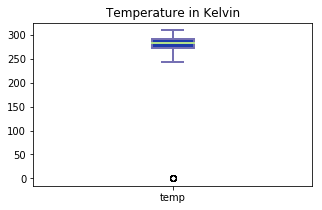

In [13]:
create_boxplot(df, ['temp'], title='Temperature in Kelvin')

The 0 temperature outlier is immediately obvious

Excluding the outlier in the __'temp'__ column we get:

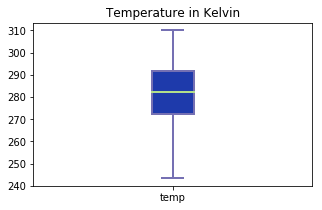

In [14]:
temp_df = df.filter(df['temp'] > 0)
create_boxplot(temp_df, ['temp'], title='Temperature in Kelvin')

#### Column __'rain_1h'__: Numeric Amount in mm of rain that occurred in the hour

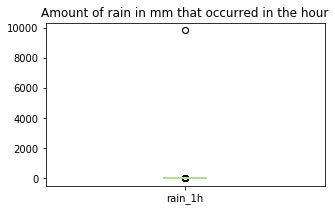

In [15]:
create_boxplot(df, ['rain_1h'], title='Amount of rain in mm that occurred in the hour')

The outlier 9831.3 is shown

Excluding the outlier in the 'rain_h' column we get:

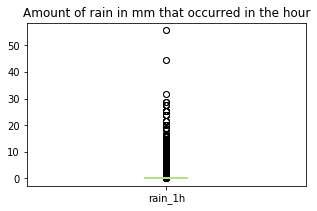

In [16]:
temp_df = df.filter(df['rain_1h'] < 900)
create_boxplot(temp_df, ['rain_1h'], title='Amount of rain in mm that occurred in the hour')
del temp_df

There are still outliers but they are valid

#### Column __'snow_1h'__: Numeric Amount in mm of snow that occurred in the hour

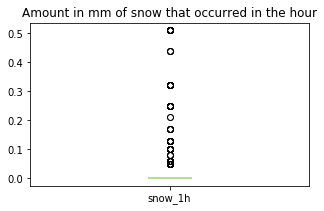

In [17]:
create_boxplot(df, ['snow_1h'], title='Amount in mm of snow that occurred in the hour')

Nothing special about the values of __'snow_1h'__ is observed. Some outliers but still valid

#### Column __'clouds_all'__: Numeric Percentage of cloud cover

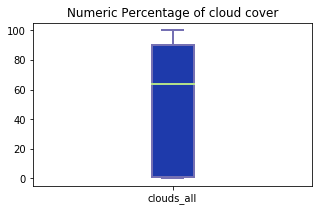

In [18]:
create_boxplot(df, ['clouds_all'], title='Numeric Percentage of cloud cover')

Again, nothing special about the values of __'clouds_all'__ is observed. There are NO outliers

__Let's plot the columms 'clouds_all', 'weather_main', 'weather_description' in relation to each other__

Number of samples taken from the data set: 222


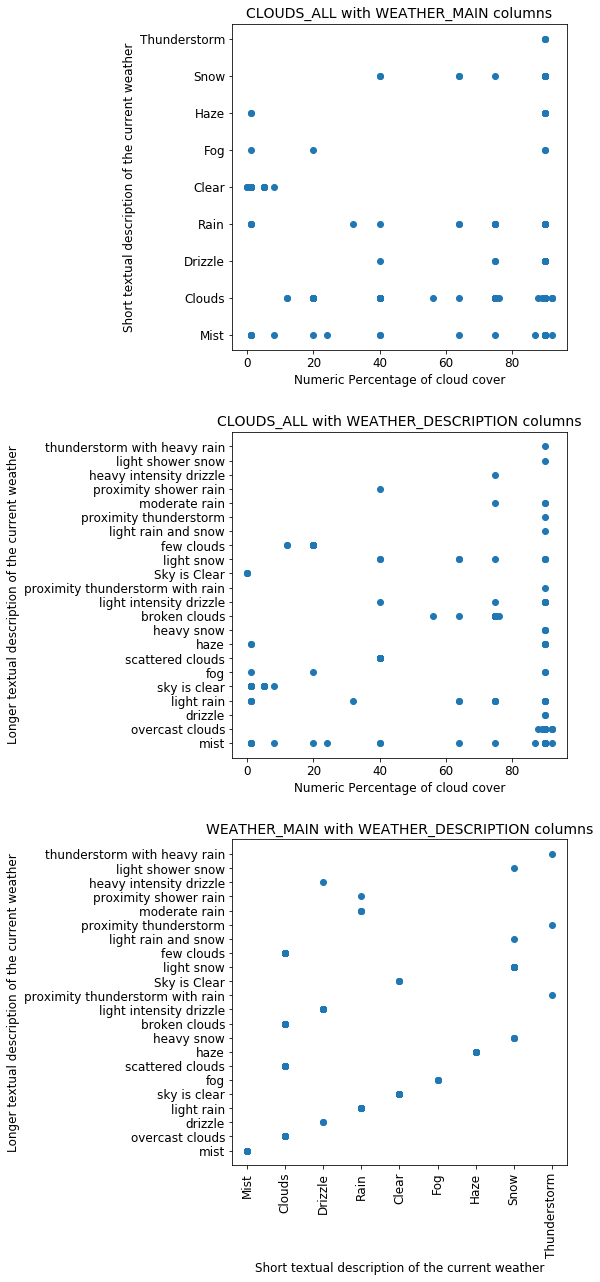

In [19]:
#clouds_all: Numeric Percentage of cloud cover
#weather_main: Categorical Short textual description of the current weather
#weather_description: Categorical Longer textual description of the current weather
plt.rcParams['font.size'] = 12
result = spark.sql('select clouds_all, weather_main, weather_description from df')
result_rdd = result.rdd.sample(False, 0.005).map(lambda row: (row.clouds_all, row.weather_main, row.weather_description))
result_array_clouds_all = result_rdd.map(lambda x: x[0]).collect()
result_array_weather_main = result_rdd.map(lambda x: x[1]).collect()
result_array_weather_description = result_rdd.map(lambda x: x[2]).collect()

print('Number of samples taken from the data set: {}'.format(result_rdd.count()))

f, axs = plt.subplots(nrows=3, ncols=1)
f.set_size_inches(6, 21)
axs[0].scatter(result_array_clouds_all, result_array_weather_main)
axs[0].set_title('CLOUDS_ALL with WEATHER_MAIN columns', fontSize=14)
axs[0].set_xlabel('Numeric Percentage of cloud cover')
axs[0].set_ylabel('Short textual description of the current weather')
axs[1].scatter(result_array_clouds_all, result_array_weather_description)
axs[1].set_title('CLOUDS_ALL with WEATHER_DESCRIPTION columns', fontSize=14)
axs[1].set_xlabel('Numeric Percentage of cloud cover')
axs[1].set_ylabel('Longer textual description of the current weather')
axs[2].scatter(result_array_weather_main, result_array_weather_description)
axs[2].set_title('WEATHER_MAIN with WEATHER_DESCRIPTION columns', fontSize=14)
axs[2].set_xlabel('Short textual description of the current weather')
axs[2].set_ylabel('Longer textual description of the current weather')
plt.xticks(rotation=90)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
f.subplots_adjust(hspace = 0.25)
plt.show()

There does not seem to be any linear correlation between these three columns.

## __Summary__

The following observations were made through the initial data exploration:
* There are duplicates in the data set.  
* The __temperature__ column has an extreme outlier with value 0. The temperature is measured in Kelvin and absolute 0 is an impossible temperature -> Celsius = Kelvin - 273.15
* The __rain_1h__ column has an extreme outlier with value: 9831.3

The above issues along with additional data quality issues will be dealt with in the 'Data Cleansing' phase